In [ ]:
# pip install prophet

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import warnings

# Ignore warnings to keep the output clean
warnings.filterwarnings('ignore')

In [2]:
# Load input data files
fact_sales = pd.read_csv("Fact-sales.csv")
date_dimension  = pd.read_csv("DateDimensionTable.csv")
product_dimension = pd.read_csv("ProductDimensionTable.csv")
store_dimension = pd.read_csv("StoreDimensionTable.csv")

In [3]:
fact_sales.head()

,SalesKey,DateKey,channelKey,StoreKey,ProductKey,PromotionKey,CurrencyKey,UnitCost,UnitPrice,SalesQuantity,ReturnQuantity,ReturnAmount,DiscountQuantity,DiscountAmount,TotalCost,SalesAmount,ETLLoadID,LoadDate,UpdateDate
0,1,2007-01-02 00:00:00.000,1,209,956,10,1,91.05,198.0,8,0,0.0,1,39.600,728.40,1544.400,1,2010-01-01 00:00:00.000,2010-01-01 00:00:00.000
1,2,2007-02-12 00:00:00.000,4,308,766,2,1,10.15,19.9,4,0,0.0,1,0.995,40.60,78.605,1,2010-01-01 00:00:00.000,2010-01-01 00:00:00.000
2,3,2008-01-24 00:00:00.000,1,156,1175,11,1,209.03,410.0,9,0,0.0,3,61.500,1881.27,3628.500,1,2010-01-01 00:00:00.000,2010-01-01 00:00:00.000
3,4,2008-01-13 00:00:00.000,2,306,1429,10,1,132.90,289.0,8,0,0.0,1,57.800,1063.20,2254.200,1,2010-01-01 00:00:00.000,2010-01-01 00:00:00.000
4,5,2008-01-22 00:00:00.000,2,306,1133,10,1,144.52,436.2,24,0,0.0,3,261.720,3468.48,10207.080,1,2010-01-01 00:00:00.000,2010-01-01 00:00:00.000


In [4]:
# Rename 'DateKey' to 'Datekey' in fact_sales for consistency
fact_sales.rename(columns={'DateKey': 'Datekey'}, inplace=True)

In [5]:
product_dimension.head()

,ProductKey,ProductLabel,ProductName,ProductDescription,ProductSubcategoryKey,Manufacturer,BrandName,ClassID,ClassName,StyleID,...,UnitCost,UnitPrice,AvailableForSaleDate,StopSaleDate,Status,ImageURL,ProductURL,ETLLoadID,LoadDate,UpdateDate
0,1,101001,Contoso 512MB MP3 Player E51 Silver,512MB USB driver plays MP3 and WMA,1,"Contoso, Ltd",Contoso,1,Economy,1.0,...,6.62,12.99,2005-05-03 00:00:00.000,NaN,On,NaN,NaN,1,2008-05-25 08:01:12.000,2008-05-25 08:01:12.000
1,2,101002,Contoso 512MB MP3 Player E51 Blue,512MB USB driver plays MP3 and WMA,1,"Contoso, Ltd",Contoso,1,Economy,5.0,...,6.62,12.99,2005-05-03 00:00:00.000,NaN,On,NaN,NaN,1,2008-05-26 08:01:12.000,2008-05-26 08:01:12.000
2,3,101003,Contoso 1G MP3 Player E100 White,1GB flash memory and USB driver plays MP3 and WMA,1,"Contoso, Ltd",Contoso,1,Economy,1.0,...,7.40,14.52,2006-05-13 00:00:00.000,NaN,On,NaN,NaN,1,2008-05-27 08:01:12.000,2008-05-27 08:01:12.000
3,4,101004,Contoso 2G MP3 Player E200 Silver,"2GB flash memory, LCD display, plays MP3 and WMA",1,"Contoso, Ltd",Contoso,1,Economy,1.0,...,11.00,21.57,2006-12-16 00:00:00.000,NaN,On,NaN,NaN,1,2008-05-28 08:01:12.000,2008-05-28 08:01:12.000
4,5,101005,Contoso 2G MP3 Player E200 Red,"2GB flash memory, LCD display, plays MP3 and WMA",1,"Contoso, Ltd",Contoso,1,Economy,1.0,...,11.00,21.57,2006-12-17 00:00:00.000,NaN,On,NaN,NaN,1,2008-05-29 08:01:12.000,2008-05-29 08:01:12.000


In [6]:
store_dimension.head()

,StoreKey,GeographyKey,StoreManager,StoreType,StoreName,StoreDescription,Status,OpenDate,CloseDate,EntityKey,...,AddressLine2,CloseReason,EmployeeCount,SellingAreaSize,LastRemodelDate,GeoLocation,Geometry,ETLLoadID,LoadDate,UpdateDate
0,1,693,35,Store,Contoso Seattle No.1 Store,Contoso Seattle No.1 Store,On,2004-04-12 00:00:00.000,NaN,635,...,East Queen Anne Big shopping mall,NaN,17.0,462,2009-06-16 00:00:00.000,0xE6100000010CB81E85EB51D047404A0C022B87965EC0,0x00000000010C4A0C022B87965EC0B81E85EB51D04740,1,2009-06-05 00:00:00.000,2009-06-05 00:00:00.000
1,2,693,35,Store,Contoso Seattle No.2 Store,Contoso Seattle No.2 Store,On,2004-02-14 00:00:00.000,NaN,636,...,Mino shopping mall,NaN,25.0,700,2009-06-17 00:00:00.000,0xE6100000010C17B7D100DED247400000000000985EC0,0xE6100000010C0000000000985EC017B7D100DED24740,1,2009-06-05 00:00:00.000,2009-06-05 00:00:00.000
2,3,856,36,Store,Contoso Kennewick Store,Contoso Kennewick Store,On,2004-02-12 00:00:00.000,NaN,934,...,"Kennewick, Downtown",NaN,26.0,680,2009-06-18 00:00:00.000,0xE6100000010C8B6CE7FBA9194740DD24068195CB5DC0,0x00000000010CDD24068195CB5DC08B6CE7FBA9194740,1,2008-11-21 00:00:00.000,2008-11-21 00:00:00.000
3,4,424,37,Store,Contoso Bellevue Store,Contoso Bellevue Store,On,2004-03-01 00:00:00.000,NaN,638,...,West Lake Hills shopping mall,NaN,19.0,455,2009-06-16 00:00:00.000,0xE6100000010CA2B437F8C2CC4740C520B07268895EC0,0x00000000010CC520B07268895EC0A2B437F8C2CC4740,1,2009-07-01 00:00:00.000,2009-07-01 00:00:00.000
4,5,677,38,Store,Contoso Redmond Store,Contoso Redmond Store,On,2004-04-02 00:00:00.000,NaN,639,...,Downtown shopping mall,NaN,33.0,560,2009-06-17 00:00:00.000,0xE6100000010C67D5E76A2BD647408195438B6C875EC0,0x00000000010C8126C286A7875EC092CB7F48BFD54740,1,2009-06-13 00:00:00.000,2009-06-13 00:00:00.000


In [7]:
date_dimension.head()

,Datekey,FullDateLabel,DateDescription,CalendarYear,CalendarYearLabel,CalendarHalfYear,CalendarHalfYearLabel,CalendarQuarter,CalendarQuarterLabel,CalendarMonth,...,FiscalQuarter,FiscalQuarterLabel,FiscalMonth,FiscalMonthLabel,IsWorkDay,IsHoliday,HolidayName,EuropeSeason,NorthAmericaSeason,AsiaSeason
0,2005-01-01 00:00:00.000,2005-01-01,2005/01/01,2005,Year 2005,20051,H1,20051,Q1,200501,...,20051,Q1,200501,Month 1,WeekEnd,0,NaN,Holiday,Spring/Back to Business,Holiday
1,2005-01-02 00:00:00.000,2005-01-02,2005/01/02,2005,Year 2005,20051,H1,20051,Q1,200501,...,20051,Q1,200501,Month 1,WeekEnd,0,NaN,Holiday,Spring/Back to Business,Holiday
2,2005-01-03 00:00:00.000,2005-01-03,2005/01/03,2005,Year 2005,20051,H1,20051,Q1,200501,...,20051,Q1,200501,Month 1,WorkDay,0,NaN,Holiday,Spring/Back to Business,Holiday
3,2005-01-04 00:00:00.000,2005-01-04,2005/01/04,2005,Year 2005,20051,H1,20051,Q1,200501,...,20051,Q1,200501,Month 1,WorkDay,0,NaN,Holiday,Spring/Back to Business,Holiday
4,2005-01-05 00:00:00.000,2005-01-05,2005/01/05,2005,Year 2005,20051,H1,20051,Q1,200501,...,20051,Q1,200501,Month 1,WorkDay,0,NaN,Holiday,Spring/Back to Business,Holiday


In [8]:
# Merge the data into a single DataFrame based on shared keys
data = fact_sales.merge(product_dimension, on='ProductKey', how='left') \
                     .merge(store_dimension, on='StoreKey', how='left') \
                     .merge(date_dimension, on='Datekey', how='left')

In [9]:
data.columns.values

array(['SalesKey', 'Datekey', 'channelKey', 'StoreKey', 'ProductKey',
       'PromotionKey', 'CurrencyKey', 'UnitCost_x', 'UnitPrice_x',
       'SalesQuantity', 'ReturnQuantity', 'ReturnAmount',
       'DiscountQuantity', 'DiscountAmount', 'TotalCost', 'SalesAmount',
       'ETLLoadID_x', 'LoadDate_x', 'UpdateDate_x', 'ProductLabel',
       'ProductName', 'ProductDescription', 'ProductSubcategoryKey',
       'Manufacturer', 'BrandName', 'ClassID', 'ClassName', 'StyleID',
       'StyleName', 'ColorID', 'ColorName', 'Size', 'SizeRange',
       'SizeUnitMeasureID', 'Weight', 'WeightUnitMeasureID',
       'UnitOfMeasureID', 'UnitOfMeasureName', 'StockTypeID',
       'StockTypeName', 'UnitCost_y', 'UnitPrice_y',
       'AvailableForSaleDate', 'StopSaleDate', 'Status_x', 'ImageURL',
       'ProductURL', 'ETLLoadID_y', 'LoadDate_y', 'UpdateDate_y',
       'GeographyKey', 'StoreManager', 'StoreType', 'StoreName',
       'StoreDescription', 'Status_y', 'OpenDate', 'CloseDate',
       'EntityKey

In [10]:
# Select relevant columns for analysis
df = data[['Datekey','StoreKey','ProductKey','SalesAmount','PromotionKey','CurrencyKey','UnitCost_x','UnitPrice_x',
           'SalesQuantity','ReturnQuantity','ReturnAmount','CalendarYear','CalendarMonth','CalendarWeek','IsHoliday',
           'IsWorkDay', 'EuropeSeason', 'NorthAmericaSeason', 'AsiaSeason']]

In [11]:
# Create binary columns for holiday information based on seasonal data

df['is_NA_Season_holday'] = df['NorthAmericaSeason'].apply(lambda x: 1 if x == 'Holiday' else 0)
# Drop the old column
df.drop('NorthAmericaSeason', axis=1, inplace=True)
df['is_EU_Season_holday'] = df['EuropeSeason'].apply(lambda x: 1 if x == 'Holiday' else 0)
# Drop the old column
df.drop('EuropeSeason', axis=1, inplace=True)
df['is_AS_Season_holday'] = df['AsiaSeason'].apply(lambda x: 1 if x == 'Holiday' else 0)
# Drop the old column
df.drop('AsiaSeason', axis=1, inplace=True)
df['is_holiday'] = df['IsWorkDay'].apply(lambda x: 1 if x == 'WeekEnd' else 0)
# Drop the old column
df.drop('IsWorkDay', axis=1, inplace=True)


In [12]:
# Convert 'Datekey' to datetime and extract date only
df['Datekey'] = pd.to_datetime(df['Datekey']).dt.date
# Extract numeric values from 'CalendarMonth' and 'CalendarWeek'
df['CalendarMonth'] = df['CalendarMonth'].astype(str).str[4:].astype(int)
df['CalendarWeek'] = df['CalendarWeek'].astype(str).str[4:].astype(int)

In [13]:
df['NetSalesAmount'] = df['SalesAmount'] - df['ReturnAmount']

In [14]:
df.shape

(3406089, 20)

In [15]:
df.StoreKey.nunique()

306

In [16]:
df.head(10)

,Datekey,StoreKey,ProductKey,SalesAmount,PromotionKey,CurrencyKey,UnitCost_x,UnitPrice_x,SalesQuantity,ReturnQuantity,ReturnAmount,CalendarYear,CalendarMonth,CalendarWeek,IsHoliday,is_NA_Season_holday,is_EU_Season_holday,is_AS_Season_holday,is_holiday,NetSalesAmount
0,2007-01-02,209,956,1544.400,10,1,91.05,198.00,8,0,0.0,2007,1,1,0,0,1,1,0,1544.400
1,2007-02-12,308,766,78.605,2,1,10.15,19.90,4,0,0.0,2007,2,7,0,0,0,0,0,78.605
2,2008-01-24,156,1175,3628.500,11,1,209.03,410.00,9,0,0.0,2008,1,4,0,0,1,1,0,3628.500
3,2008-01-13,306,1429,2254.200,10,1,132.90,289.00,8,0,0.0,2008,1,3,0,0,1,1,1,2254.200
4,2008-01-22,306,1133,10207.080,10,1,144.52,436.20,24,0,0.0,2008,1,4,0,0,1,1,0,10207.080
5,2007-07-02,200,2365,13999.650,3,1,183.94,399.99,36,0,0.0,2007,7,27,0,0,0,0,0,13999.650
6,2007-11-19,310,1016,843.600,5,1,68.06,148.00,6,0,0.0,2007,11,47,0,1,1,1,0,843.600
7,2008-04-10,307,138,4399.912,15,1,229.93,499.99,9,0,0.0,2008,4,15,0,0,0,0,0,4399.912
8,2008-07-14,199,1731,1702.575,12,1,33.32,72.45,24,0,0.0,2008,7,29,0,0,0,0,0,1702.575
9,2009-04-10,310,497,1702.800,24,1,50.47,99.00,18,0,0.0,2009,4,15,0,0,0,0,0,1702.800


In [17]:
# Define a function to forecast sales for a specific store-product combination

from sklearn.metrics import mean_absolute_error, mean_squared_error

def forecast_sales(df, store_key, product_key, forecast_horizon):
    """
    Forecasts sales for a specific store-product combination using Prophet and evaluates the model.

    Args:
        df: The DataFrame containing historical sales data.
        store_key: The key for the store.
        product_key: The key for the product.
        forecast_horizon: The number of days to forecast into the future.
        test_size: The proportion of data to use for testing.

    Returns:
        A DataFrame containing the forecasted sales and evaluation metrics.
    """

    # Filter data for the specific store-product combination
    filtered_df = df[(df['StoreKey'] == store_key) & (df['ProductKey'] == product_key)]


    # Handle missing values (adjust as needed)
    filtered_df['SalesAmount'].fillna(method='ffill', inplace=True)
    

    # Prepare the data for Prophet
    df_prophet = filtered_df[['Datekey', 'SalesAmount']]
    df_prophet.columns = ['ds', 'y']

    # Split data into training and testing sets
    # train_size = int(len(df_prophet) * (1 - test_size))
    # train_df, test_df = df_prophet[:train_size], df_prophet[train_size:]
#     split_date = '2009-01-01' # Choose your split date
#     date_object = datetime.strptime(split_date, '%Y-%m-%d').date()

#     train_df = df_prophet[df_prophet['ds'] < date_object]  # Training data

#     test_df = df_prophet[df_prophet['ds'] >= date_object]  # Testing data


    # Create and fit the Prophet model
#     model = Prophet()
#     model.fit(train_df)

#     # Make predictions on the test set
#     forecast = model.predict(test_df)
    # print(forecast)
    

#     # Evaluate the model
#     mae = mean_absolute_error(test_df['y'], forecast['yhat'])
#     mse = mean_squared_error(test_df['y'], forecast['yhat'])
#     rmse = np.sqrt(mse)

#     print("Mean Absolute Error:", mae)
#     print("Mean Squared Error:", mse)
#     print("Root Mean Squared Error:", rmse)
    model = Prophet()
    model.fit(df_prophet)


    # Forecast for the future
    future = model.make_future_dataframe(periods=forecast_horizon, include_history=False)
    future_forecast = model.predict(future)
    # print(future_forecast)

    # Handle negative forecasts (e.g., cap at zero or use a more complex approach)
    future_forecast['yhat'] = future_forecast['yhat'].clip(lower=0)
    
    return future_forecast

In [18]:
# Define the store and product keys
store_key = [199, 306, 307, 200, 199, 306, 307, 199, 306, 307]
product_key = [1752, 1728, 1787, 1977, 1717, 1820, 1743, 1731, 1730, 1796]


# Placeholder for the final results
all_forecast_results = []

# Generate forecasts for 10 unique store-product combinations
for store_key, product_key in zip(store_key, product_key):
    # Call the forecast_sales function
    print(store_key)
    print(product_key)
    forecast_result = forecast_sales(df, store_key, product_key, forecast_horizon=365)
    
    # Select relevant columns and add store and product identifiers
    forecast_result = forecast_result[['ds', 'yhat']].copy()
    forecast_result['store_key'] = store_key
    forecast_result['product_key'] = product_key
    
    # Append to the list of all results
    all_forecast_results.append(forecast_result)

# Combine all the results into a single DataFrame
final_results_df = pd.concat(all_forecast_results, ignore_index=True)

# Save to a CSV file
output_file = 'forecast_results.csv'
final_results_df.to_csv(output_file, index=False)
print(f"Forecast results saved to {output_file}")


199
1752


19:50:48 - cmdstanpy - INFO - Chain [1] start processing
19:50:48 - cmdstanpy - INFO - Chain [1] done processing
19:50:48 - cmdstanpy - INFO - Chain [1] start processing
19:50:48 - cmdstanpy - INFO - Chain [1] done processing
19:50:48 - cmdstanpy - INFO - Chain [1] start processing
19:50:48 - cmdstanpy - INFO - Chain [1] done processing


306
1728
307
1787


19:50:48 - cmdstanpy - INFO - Chain [1] start processing
19:50:48 - cmdstanpy - INFO - Chain [1] done processing
19:50:49 - cmdstanpy - INFO - Chain [1] start processing
19:50:49 - cmdstanpy - INFO - Chain [1] done processing


200
1977
199
1717


19:50:49 - cmdstanpy - INFO - Chain [1] start processing
19:50:49 - cmdstanpy - INFO - Chain [1] done processing
19:50:49 - cmdstanpy - INFO - Chain [1] start processing
19:50:49 - cmdstanpy - INFO - Chain [1] done processing


306
1820
307
1743


19:50:49 - cmdstanpy - INFO - Chain [1] start processing
19:50:49 - cmdstanpy - INFO - Chain [1] done processing
19:50:49 - cmdstanpy - INFO - Chain [1] start processing
19:50:49 - cmdstanpy - INFO - Chain [1] done processing


199
1731
306
1730


19:50:49 - cmdstanpy - INFO - Chain [1] start processing
19:50:49 - cmdstanpy - INFO - Chain [1] done processing


307
1796
Forecast results saved to forecast_results.csv


In [19]:
final_results = final_results_df[(final_results_df['store_key'] == 199) & (final_results_df['product_key'] == 1752)]

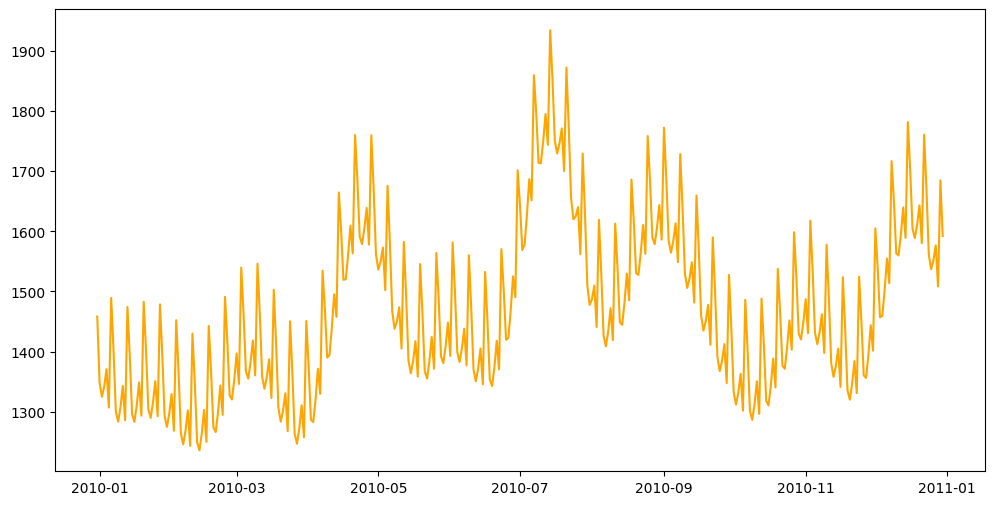

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(final_results['ds'], final_results['yhat'], label='Forecasted Sales', color='orange')
# plt.axvline(x=df_prophet['ds'].iloc[-1], color='red', linestyle='--', label='Forecast Start')
# plt.xlabel('Date')
# plt.ylabel('Sales Amount')
# plt.title(f'Sales and Forecast for Store {store_key}, Product {product_key}')
# plt.legend()
# plt.grid(True)
plt.show()